In [1]:
import os
import logging
from pathlib import Path
import datetime

from tqdm import tqdm
import numpy as np
import math
import pandas as pd
import random

import torch
from torch.utils.data import DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt

import torch.nn as nn 
from torch.nn.utils import parameters_to_vector
import torch.optim as optim
from torchinfo import summary

import torchmetrics

import cv2

import config
import dataset
import models
import loss
import metrics
import train_epoch
import val_epoch
import utils

In [2]:
#torch.cuda.empty_cache()

# Logger

In [3]:
log_path = config.LOGS_FOLDER

logger = logging.getLogger("GonLogger")
logger.propagate = False
logger.setLevel(logging.INFO)
file_handler = logging.FileHandler(log_path + 'logfile.log')
formatter = logging.Formatter('%(message)s')
file_handler.setFormatter(formatter)

# add file handler to logger
logger.addHandler(file_handler)

logger.info('BED Classifier XS Tiny.\n' +  
            '\tOne Head.\n' +
            '\t255 Normalization.\n' +
            '\tWeighted for Precision.\n' +
            '\tModules.\n'+ 
            '\tLosses and Metrics Loggers.\n' +
            '\tMore checkpoints.\n' +
            '\t140 epochs.\n' + 
            '\tAffine True for all BatchNorm Modules: fixed, as I forgot one module in previous experiment.\n')

# View Dataset

### Transform

In [4]:
view_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.OneOf([
            A.RandomBrightnessContrast(p=0.4),
            A.HueSaturationValue(hue_shift_limit=10, p=0.2),
            A.Blur(blur_limit=(3,3), p=0.3),
            A.CLAHE(clip_limit=2.0, p=0.3),
            A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        ], p=0.9),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.Resize(config.IMG_H, config.IMG_W, p=1),
        ToTensorV2(p=1),
    ]
)

In [5]:
VIEW_BATCH_SIZE = 32

view_dfire_ds = dataset.DFireDataset(
    img_h=config.IMG_H, 
    img_w=config.IMG_W, 
    img_dir=config.val_imgs, 
    label_dir=config.val_labels, 
    num_classes=config.N_CLASSES,
    ds_len=2*VIEW_BATCH_SIZE,
    transform=view_transform)

view_loader = DataLoader(dataset=view_dfire_ds,
                         batch_size=VIEW_BATCH_SIZE,
                         num_workers=1,
                         pin_memory=True,
                         shuffle=True,
                         drop_last=False)
print(f'Val dataset length: {len(view_dfire_ds)}')

DFire Removed wrong images: 0
DFire empty images: 31
DFire only smoke images: 17
DFire only fire images: 2
DFire smoke and fire images: 14
Val dataset length: 64


# Plot Dataset Pictures

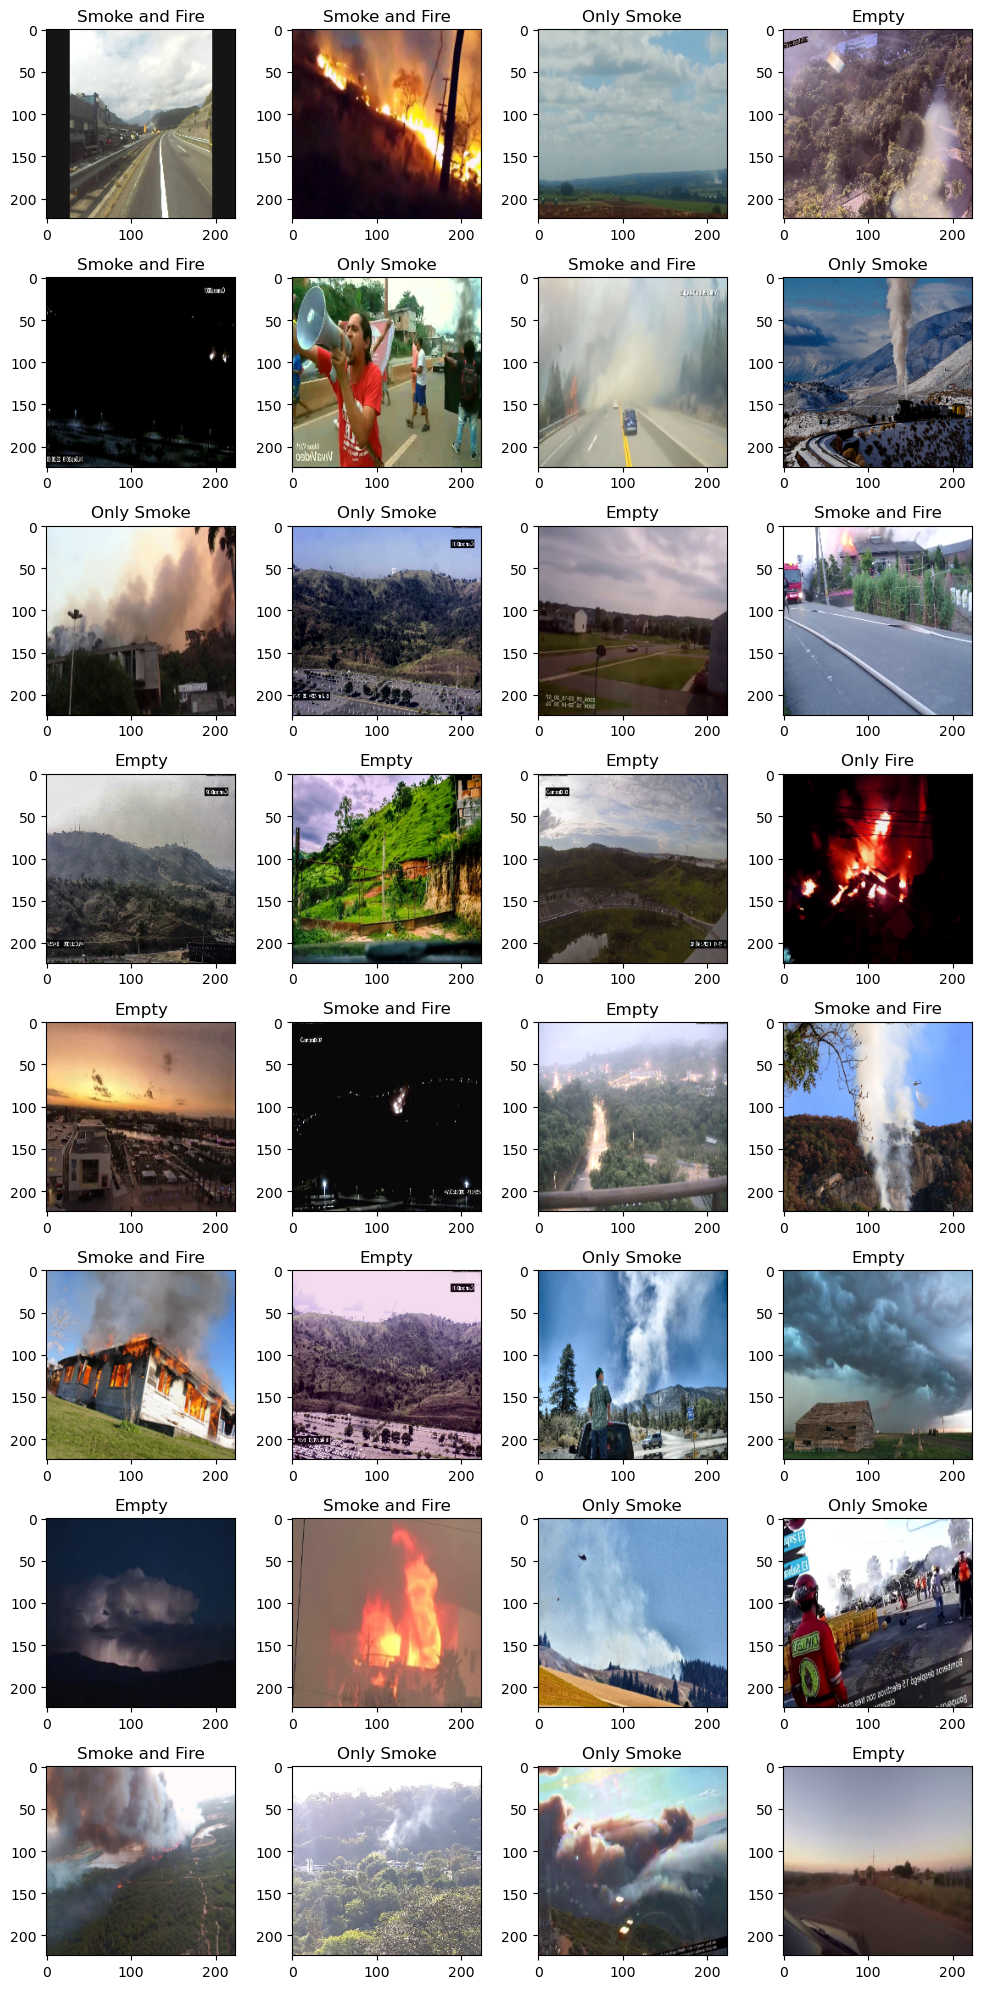

In [6]:
for i, (img, label) in enumerate(view_loader):

    plt.subplots(8,4, figsize=(10, 20))
    
    for idx in range(VIEW_BATCH_SIZE):
        plt.subplot(8, 4, idx+1)
        plt.imshow(img[idx].permute(1, 2, 0))
        title = ""
        if label[idx][0] == 1 and label[idx][1] == 1:
            title += "Smoke and Fire"
        elif label[idx][0] == 1 and label[idx][1] == 0:
            title += "Only Smoke"
        elif label[idx][0] == 0 and label[idx][1] == 1:
            title += "Only Fire"
        else:
            title += "Empty"
        plt.title(title)
        
        if (idx == 31):
            break
    plt.tight_layout()
    plt.show()
    break

# Dataset Setup

In [7]:
train_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.OneOf([
            A.RandomBrightnessContrast(p=0.4),
            A.HueSaturationValue(hue_shift_limit=10, p=0.2),
            A.Blur(blur_limit=(3,3), p=0.3),
            A.CLAHE(clip_limit=2.0, p=0.3),
            A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        ], p=0.9),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.Resize(config.IMG_H, config.IMG_W, p=1),
        #A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1),
        ToTensorV2(p=1),
    ]
)

# TRAIN DATASET
print("\nTRAIN DFIRE dataset")
logger.info("\nTRAIN DFIRE dataset")
train_dataset = dataset.DFireDataset(
    img_h = config.IMG_H,
    img_w = config.IMG_W,
    img_dir = config.TRAIN_IMG_DIR,
    label_dir = config.TRAIN_LABEL_DIR,
    num_classes=config.N_CLASSES,
    ds_len = config.DS_LEN,
    transform=train_transform)

print(f'Train dataset len: {len(train_dataset)}')
logger.info(f'\tTrain dataset len: {len(train_dataset)}')


# VALIDATION DATASET
val_transform = A.Compose([
    A.Resize(config.IMG_H, config.IMG_W, p=1),
    ToTensorV2(p=1),
    ]
)

print("\nTEST DFire dataset")
logger.info("TEST DFire dataset")
val_dataset = dataset.DFireDataset(
    img_h = config.IMG_H,
    img_w = config.IMG_W,
    img_dir = config.VAL_IMG_DIR,
    label_dir = config.VAL_LABEL_DIR,
    num_classes = config.N_CLASSES,
    ds_len = config.DS_LEN,
    transform=val_transform)

print(f'Test dataset len: {len(val_dataset)}')
logger.info(f'\tTest dataset len: {len(val_dataset)}')


# LOADERS
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=config.BATCH_SIZE,
                          num_workers=config.NUM_WORKERS,
                          pin_memory=config.PIN_MEMORY,
                          shuffle=True,
                          drop_last=True)

val_loader = DataLoader(dataset=val_dataset,
                        batch_size=config.BATCH_SIZE,
                        num_workers=config.NUM_WORKERS,
                        pin_memory=config.PIN_MEMORY,
                        shuffle=False,
                        drop_last=True)


TRAIN DFIRE dataset
DFire Removed wrong images: 0
DFire empty images: 7833
DFire only smoke images: 4681
DFire only fire images: 944
DFire smoke and fire images: 3763
Train dataset len: 17221

TEST DFire dataset
DFire Removed wrong images: 0
DFire empty images: 2005
DFire only smoke images: 1186
DFire only fire images: 220
DFire smoke and fire images: 895
Test dataset len: 4306


# Model Setup

In [8]:
if config.MODEL == "BED":
    print("Using BED Classifier")
    logger.info("\nUsing BED Classifier")
    fp32_model = models.BED_CLASSIFIER(num_classes=config.N_CLASSES).to(config.DEVICE)   
else:
    print("Wrong Model")
    logger.info("Wrong Model")
    raise SystemExit("Wrong Model")

optimizer = optim.Adam(fp32_model.parameters(), 
                       lr=config.LEARNING_RATE, 
                       weight_decay=config.WEIGHT_DECAY)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                 mode='min',
                                                 factor=config.FACTOR, 
                                                 patience=config.PATIENCE, 
                                                 threshold=config.THRES, 
                                                 threshold_mode='abs',
                                                 min_lr=config.MIN_LR)

# MODEL PARAMETERS
n_trainable = sum(p.numel() for p in fp32_model.parameters() if p.requires_grad)
print(f'\nTrainable parameters = {n_trainable}')
logger.info(f'\nTrainable parameters = {n_trainable}')

n_params = parameters_to_vector(fp32_model.parameters()).numel()
print(f'Total parameters = {n_params}\n')
logger.info(f'Total parameters = {n_params}\n')

Using BED Classifier

Trainable parameters = 93266
Total parameters = 93266



### Check Model Shape

In [9]:
in_rand_np = np.random.rand(4, 3, config.IMG_H, config.IMG_W)
in_rand = torch.tensor(in_rand_np, dtype=torch.float32, device=config.DEVICE)
out_test = fp32_model(in_rand)
print(f'Model shape is {out_test}')
print(f'BED Model Arquitecture\n{fp32_model}')
logger.info(f'Model shape is {out_test}')
logger.info(f'BED Model Arquitecture\n{fp32_model}')

Model shape is tensor([[-0.0732,  0.2019],
        [-0.1578,  0.2426],
        [-0.1125,  0.1772],
        [-0.1215,  0.1722]], device='cuda:0', grad_fn=<AddmmBackward0>)
BED Model Arquitecture
BED_CLASSIFIER(
  (model): Sequential(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (dropout1): Dropout2d(p=0.3, inplace=False)
    (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU()
    (dropout2): Dropout2d(p=0.3, inplace=False)
    (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv31): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn31)

# Torchinfo: model summary

### FP32 Model

In [10]:
print(summary(fp32_model, input_size=(config.BATCH_SIZE, 3, config.IMG_H, config.IMG_W)))
logger.info(summary(fp32_model, input_size=(config.BATCH_SIZE, 3, config.IMG_H, config.IMG_W)))

Layer (type:depth-idx)                   Output Shape              Param #
BED_CLASSIFIER                           [64, 2]                   --
├─Sequential: 1-1                        [64, 2]                   --
│    └─Conv2d: 2-1                       [64, 32, 224, 224]        864
│    └─BatchNorm2d: 2-2                  [64, 32, 224, 224]        64
│    └─ReLU: 2-3                         [64, 32, 224, 224]        --
│    └─Dropout2d: 2-4                    [64, 32, 224, 224]        --
│    └─MaxPool2d: 2-5                    [64, 32, 112, 112]        --
│    └─Conv2d: 2-6                       [64, 16, 112, 112]        4,608
│    └─BatchNorm2d: 2-7                  [64, 16, 112, 112]        32
│    └─ReLU: 2-8                         [64, 16, 112, 112]        --
│    └─Dropout2d: 2-9                    [64, 16, 112, 112]        --
│    └─MaxPool2d: 2-10                   [64, 16, 56, 56]          --
│    └─Conv2d: 2-11                      [64, 16, 56, 56]          256
│    └─Bat

# Loss Function

In [11]:
if config.LOSS_FN == "BCE":
    print(f'Loss Function: BCE')
    logger.info(f'\nLoss Function: BCE')
    print(f'Smoke Precision Weight: {config.SMOKE_PRECISION_WEIGHT}')
    logger.info(f'Smoke Precision Weight: {config.SMOKE_PRECISION_WEIGHT}')
    loss_fn = loss.BCE_LOSS(device=config.DEVICE, smoke_precision_weight=config.SMOKE_PRECISION_WEIGHT)
else:
    print("Wrong loss function")
    logger.info("Wrong loss function")
    raise SystemExit("Wrong loss function")

Loss Function: BCE
Smoke Precision Weight: 0.8


# Print and Log Config Values

In [12]:
''' ============================
    Print Config Values
============================ '''
print(f'\nDevice: {config.DEVICE}')
print(f'Learning Rate: {config.LEARNING_RATE}')
print(f'Weight Decay: {config.WEIGHT_DECAY}')
print(f'Batch Size: {config.BATCH_SIZE}')
print(f'IMG DIMS: ({config.IMG_H}, {config.IMG_W})')

logger.info(f'\nDevice: {config.DEVICE}')
logger.info(f'Learning Rate: {config.LEARNING_RATE}')
logger.info(f'Optimizer Weight Decay: {config.WEIGHT_DECAY}')
logger.info(f'Scheduler factor: {config.FACTOR}')
logger.info(f'Scheduler patience: {config.PATIENCE}')
logger.info(f'Scheduler threshold: {config.THRES}')
logger.info(f'Scheduler min learning rate: {config.MIN_LR}')
logger.info(f'Batch Size: {config.BATCH_SIZE}')
logger.info(f'W: {config.IMG_W}\nH: {config.IMG_H}')


Device: cuda
Learning Rate: 0.001
Weight Decay: 0.001
Batch Size: 64
IMG DIMS: (224, 224)


# Loss and Metrics Loggers and Plotters

In [13]:
train_losses_logger = utils.LogLosses()
train_metrics_logger = utils.LogMetrics()
lr_logger = utils.LogLR(log_path=config.PLOTS_FOLDER)

val_losses_logger = utils.LogLosses()
val_metrics_logger = utils.LogMetrics()

loss_plotter = utils.PlotMetrics(log_path=config.PLOTS_FOLDER, model_name=config.MODEL, loss_or_metric='Loss')
metrics_plotter = utils.PlotMetrics(log_path=config.PLOTS_FOLDER, model_name=config.MODEL, loss_or_metric='Metric')

# Main Function

In [14]:
def train_loop(model, start_epoch=0):

    ''' ==============================================================
                                TRAINING LOOP
    ============================================================== '''
    start = datetime.datetime.now()
    start_time = start.strftime("%H:%M:%S")
    print(f'\n***Start Training: {start_time}\n')
    logger.info(f'\n***Start Training: {start_time}\n')
    
    # Start with infinite validation loss
    best_valid_loss = np.inf
    best_smoke_precision = 0. #torch.tensor([0.])
    smoke_f1_min_save = 0.9 #torch.tensor([0.9])

    #start_epoch = 0
    epochs_plot = []
        
    for epoch in range(start_epoch, config.EPOCHS):

        print(f'\n=== EPOCH {epoch}/{config.EPOCHS-1} ===')
        logger.info(f'\n=== EPOCH {epoch}/{config.EPOCHS-1} ===')
        
        #====================== TRAINING ========================#
        current_lr = train_epoch.get_lr(optimizer=optimizer)
        logger.info(f'Learning Rate = {current_lr:.6f}\n')
        lr_logger.log_lr(current_lr)
                
        train_losses, train_metrics = train_epoch.train_fn(
            loader=train_loader, 
            model=model, 
            optimizer=optimizer, 
            loss_fn=loss_fn,
            device=config.DEVICE)
        
        train_losses_logger.update_metrics(train_losses)
        train_metrics_logger.update_metrics(train_metrics)
                
        logger.info(utils.print_metrics_to_logger("TRAIN Stats", train_losses, train_metrics))
        
        #===================== VALIDATING =======================#
        with torch.no_grad():
            val_losses, val_metrics = val_epoch.eval_fn(
                loader=val_loader, 
                model=model,                         
                loss_fn=loss_fn,
                device=config.DEVICE)
            
            scheduler.step(val_losses['Total'])
            
            val_losses_logger.update_metrics(val_losses)
            val_metrics_logger.update_metrics(val_metrics)

            logger.info(utils.print_metrics_to_logger("VAL Stats", val_losses, val_metrics))
            
        epochs_plot.append(epoch)

        loss_plotter.plot_all_metrics(
            train_losses_logger.get_metrics(),
            val_losses_logger.get_metrics(),
            epochs_plot)

        metrics_plotter.plot_all_metrics(
            train_metrics_logger.get_metrics(),
            val_metrics_logger.get_metrics(),
            epochs_plot)

        lr_logger.plot_lr(epochs_plot)
        
        #======================= SAVING =========================#
        if ( (epoch+1) % 5 ) == 0:
            save_name = config.WEIGHTS_FOLDER + config.MODEL + '_classifier__5epoch.pt'
            utils.save_checkpoint(epoch, model, optimizer, scheduler, save_name) 
            
        if best_valid_loss > val_losses['Total']:
            best_valid_loss = val_losses['Total']
            print(f"\nSaving model with new best validation loss: {best_valid_loss:.3f}")
            logger.info(f"Saving model with new best validation loss: {best_valid_loss:.3f}")
            save_name = config.WEIGHTS_FOLDER + config.MODEL + '_classifier__' + 'best_loss'  + '.pt'
            utils.save_checkpoint(epoch, model, optimizer, scheduler, save_name)  

        # Save model if precision increases and F1 > 0.9
        if ( best_smoke_precision < val_metrics['Precision'][0] ) and ( val_metrics['F1'][0] > smoke_f1_min_save ) :
            best_smoke_precision = val_metrics['Precision'][0]
            print(f"\nSaving model with new best smoke precision: {best_smoke_precision:.3f}")
            logger.info(f"Saving model with new best smoke precision: {best_smoke_precision:.3f}")
            save_precision_name = f'best_smoke__precision={np.round(best_smoke_precision, decimals=4)}__epoch={epoch}'
            save_name = config.WEIGHTS_FOLDER + config.MODEL + '_classifier__' + save_precision_name + '.pt'
            utils.save_checkpoint(epoch, model, optimizer, scheduler, save_name)  
            
        # Save model if precision > 0.9 and recall > 0.9
        if ( val_metrics['Precision'][0] > 0.9 ) and ( val_metrics['Recall'][0] > 0.9 ) :
            print("\nSaving model with precision > 0.9 and recall > 0.9")
            logger.info("Saving model with precision > 0.9 and recall > 0.9")
            save_pre_name = f'smoke__precision={np.round(val_metrics["Precision"][0], decimals=4)}__' 
            save_rec_name = f'recall={np.round(val_metrics["Recall"][0], decimals=4)}__'
            save_pre_rec_name = save_pre_name + save_rec_name + f'epoch={epoch}'
            save_name = config.WEIGHTS_FOLDER + config.MODEL + '_classifier__' + save_pre_rec_name + '.pt'
            utils.save_checkpoint(epoch, model, optimizer, scheduler, save_name)  
        
    logger.info('Saving last model')   
    torch.save(model.state_dict(), config.WEIGHTS_FOLDER + 'last_' + config.MODEL + '_classifier.pt') 
    
    #======================= FINISH =========================#
    end = datetime.datetime.now()
    end_time = end.strftime("%H:%M:%S")
    print(f'\n***Script finished: {end_time}\n')  
    print(f'Time elapsed: {end-start}')
    logger.info(f'\n***Script finished: {end_time}\n')  
    logger.info(f'Time elapsed: {end-start}')
    
    return model

# Main execute

In [15]:
if __name__ == "__main__":
       
    trained_model = train_loop(model=fp32_model)


***Start Training: 12:11:06


=== EPOCH 0/139 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.09it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
69.571      |39.120      |30.451      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 26.38it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
63.547      |38.635      |24.912      
SMOKE -> Precision: 0.553 - Recall: 0.119 - Accuracy: 0.530 - F1: 0.196
FIRE -> Precision: 0.739 - Recall: 0.568 - Accuracy: 0.836 - F1: 0.642

Saving model with new best validation loss: 63.547

=== EPOCH 1/139 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.18it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
63.842      |38.171      |25.671      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 26.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
57.631      |36.887      |20.744      
SMOKE -> Precision: 0.665 - Recall: 0.367 - Accuracy: 0.606 - F1: 0.473
FIRE -> Precision: 0.757 - Recall: 0.700 - Accuracy: 0.864 - F1: 0.728

Saving model with new best validation loss: 57.631

=== EPOCH 2/139 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.06it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
59.437      |36.728      |22.709      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
55.124      |35.569      |19.555      
SMOKE -> Precision: 0.784 - Recall: 0.347 - Accuracy: 0.640 - F1: 0.481
FIRE -> Precision: 0.819 - Recall: 0.668 - Accuracy: 0.876 - F1: 0.735

Saving model with new best validation loss: 55.124

=== EPOCH 3/139 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.11it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
57.039      |35.935      |21.104      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 26.10it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
51.979      |34.439      |17.540      
SMOKE -> Precision: 0.791 - Recall: 0.420 - Accuracy: 0.667 - F1: 0.548
FIRE -> Precision: 0.817 - Recall: 0.759 - Accuracy: 0.894 - F1: 0.787

Saving model with new best validation loss: 51.979

=== EPOCH 4/139 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.12it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
55.290      |35.378      |19.912      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 26.23it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
51.180      |34.747      |16.433      
SMOKE -> Precision: 0.767 - Recall: 0.427 - Accuracy: 0.662 - F1: 0.549
FIRE -> Precision: 0.796 - Recall: 0.795 - Accuracy: 0.894 - F1: 0.795

Saving model with new best validation loss: 51.180

=== EPOCH 5/139 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.07it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
53.593      |34.891      |18.701      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.90it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
49.344      |33.517      |15.827      
SMOKE -> Precision: 0.740 - Recall: 0.524 - Accuracy: 0.682 - F1: 0.614
FIRE -> Precision: 0.769 - Recall: 0.860 - Accuracy: 0.897 - F1: 0.812

Saving model with new best validation loss: 49.344

=== EPOCH 6/139 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
52.648      |34.306      |18.342      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.87it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
47.202      |32.199      |15.003      
SMOKE -> Precision: 0.790 - Recall: 0.458 - Accuracy: 0.681 - F1: 0.579
FIRE -> Precision: 0.843 - Recall: 0.801 - Accuracy: 0.910 - F1: 0.821

Saving model with new best validation loss: 47.202

=== EPOCH 7/139 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.04it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
50.874      |33.544      |17.330      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
46.882      |32.178      |14.704      
SMOKE -> Precision: 0.760 - Recall: 0.571 - Accuracy: 0.707 - F1: 0.652
FIRE -> Precision: 0.878 - Recall: 0.786 - Accuracy: 0.916 - F1: 0.829

Saving model with new best validation loss: 46.882

=== EPOCH 8/139 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.03it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
49.598      |33.143      |16.455      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 26.16it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
44.829      |31.669      |13.160      
SMOKE -> Precision: 0.723 - Recall: 0.613 - Accuracy: 0.701 - F1: 0.664
FIRE -> Precision: 0.830 - Recall: 0.860 - Accuracy: 0.918 - F1: 0.845

Saving model with new best validation loss: 44.829

=== EPOCH 9/139 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.05it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
49.116      |32.858      |16.258      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 26.11it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
45.426      |30.988      |14.438      
SMOKE -> Precision: 0.815 - Recall: 0.516 - Accuracy: 0.711 - F1: 0.632
FIRE -> Precision: 0.908 - Recall: 0.747 - Accuracy: 0.915 - F1: 0.820

=== EPOCH 10/139 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.12it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
48.044      |32.183      |15.861      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.68it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
43.023      |30.541      |12.482      
SMOKE -> Precision: 0.763 - Recall: 0.651 - Accuracy: 0.735 - F1: 0.702
FIRE -> Precision: 0.875 - Recall: 0.832 - Accuracy: 0.926 - F1: 0.853

Saving model with new best validation loss: 43.023

=== EPOCH 11/139 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.04it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
47.522      |32.100      |15.423      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.92it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
44.441      |30.210      |14.231      
SMOKE -> Precision: 0.839 - Recall: 0.479 - Accuracy: 0.705 - F1: 0.610
FIRE -> Precision: 0.942 - Recall: 0.742 - Accuracy: 0.921 - F1: 0.830

=== EPOCH 12/139 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.01it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
46.544      |31.381      |15.163      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.46it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
41.626      |29.635      |11.991      
SMOKE -> Precision: 0.770 - Recall: 0.620 - Accuracy: 0.728 - F1: 0.687
FIRE -> Precision: 0.813 - Recall: 0.909 - Accuracy: 0.922 - F1: 0.858

Saving model with new best validation loss: 41.626

=== EPOCH 13/139 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.07it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
46.130      |31.109      |15.021      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.60it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
40.122      |28.720      |11.402      
SMOKE -> Precision: 0.806 - Recall: 0.581 - Accuracy: 0.731 - F1: 0.675
FIRE -> Precision: 0.852 - Recall: 0.879 - Accuracy: 0.929 - F1: 0.866

Saving model with new best validation loss: 40.122

=== EPOCH 14/139 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.90it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
45.089      |30.573      |14.515      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.90it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.592      |27.515      |11.077      
SMOKE -> Precision: 0.831 - Recall: 0.615 - Accuracy: 0.755 - F1: 0.707
FIRE -> Precision: 0.884 - Recall: 0.866 - Accuracy: 0.936 - F1: 0.875

Saving model with new best validation loss: 38.592

=== EPOCH 15/139 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.07it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
44.531      |30.254      |14.276      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
39.837      |29.165      |10.672      
SMOKE -> Precision: 0.705 - Recall: 0.845 - Accuracy: 0.755 - F1: 0.768
FIRE -> Precision: 0.913 - Recall: 0.857 - Accuracy: 0.942 - F1: 0.884

=== EPOCH 16/139 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
43.713      |29.750      |13.963      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.40it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
39.241      |27.719      |11.522      
SMOKE -> Precision: 0.784 - Recall: 0.749 - Accuracy: 0.780 - F1: 0.766
FIRE -> Precision: 0.937 - Recall: 0.820 - Accuracy: 0.939 - F1: 0.875

=== EPOCH 17/139 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.03it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
43.124      |29.155      |13.969      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.57it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.700      |27.182      |10.518      
SMOKE -> Precision: 0.776 - Recall: 0.753 - Accuracy: 0.777 - F1: 0.764
FIRE -> Precision: 0.891 - Recall: 0.879 - Accuracy: 0.941 - F1: 0.885

Saving model with new best validation loss: 37.700

=== EPOCH 18/139 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.02it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
42.696      |29.089      |13.607      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.81it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.103      |27.552      |10.551      
SMOKE -> Precision: 0.761 - Recall: 0.786 - Accuracy: 0.778 - F1: 0.773
FIRE -> Precision: 0.874 - Recall: 0.894 - Accuracy: 0.939 - F1: 0.884

=== EPOCH 19/139 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.90it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
41.847      |28.762      |13.084      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.65it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.785      |25.533      |11.252      
SMOKE -> Precision: 0.830 - Recall: 0.704 - Accuracy: 0.788 - F1: 0.762
FIRE -> Precision: 0.922 - Recall: 0.830 - Accuracy: 0.938 - F1: 0.873

Saving model with new best validation loss: 36.785

=== EPOCH 20/139 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.94it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
41.359      |28.292      |13.067      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.63it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.875      |24.784      |10.091      
SMOKE -> Precision: 0.837 - Recall: 0.720 - Accuracy: 0.798 - F1: 0.774
FIRE -> Precision: 0.927 - Recall: 0.850 - Accuracy: 0.944 - F1: 0.887

Saving model with new best validation loss: 34.875

=== EPOCH 21/139 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.95it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
41.321      |28.218      |13.104      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.42it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.778      |24.305      |10.473      
SMOKE -> Precision: 0.837 - Recall: 0.728 - Accuracy: 0.801 - F1: 0.778
FIRE -> Precision: 0.850 - Recall: 0.923 - Accuracy: 0.938 - F1: 0.885

Saving model with new best validation loss: 34.778

=== EPOCH 22/139 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.02it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
40.204      |27.662      |12.542      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.26it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.335      |25.406      |9.930       
SMOKE -> Precision: 0.866 - Recall: 0.589 - Accuracy: 0.758 - F1: 0.701
FIRE -> Precision: 0.921 - Recall: 0.859 - Accuracy: 0.944 - F1: 0.889

=== EPOCH 23/139 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.04it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
40.193      |27.529      |12.663      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.47it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.824      |24.000      |9.824       
SMOKE -> Precision: 0.806 - Recall: 0.801 - Accuracy: 0.811 - F1: 0.803
FIRE -> Precision: 0.899 - Recall: 0.891 - Accuracy: 0.946 - F1: 0.895

Saving model with new best validation loss: 33.824

=== EPOCH 24/139 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.03it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
39.817      |27.372      |12.445      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.39it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.732      |23.319      |9.414       
SMOKE -> Precision: 0.852 - Recall: 0.744 - Accuracy: 0.815 - F1: 0.794
FIRE -> Precision: 0.868 - Recall: 0.916 - Accuracy: 0.942 - F1: 0.891

Saving model with new best validation loss: 32.732

=== EPOCH 25/139 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.08it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
39.652      |27.198      |12.454      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.21it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.190      |23.521      |9.670       
SMOKE -> Precision: 0.870 - Recall: 0.702 - Accuracy: 0.806 - F1: 0.777
FIRE -> Precision: 0.916 - Recall: 0.877 - Accuracy: 0.947 - F1: 0.896

=== EPOCH 26/139 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.837      |26.540      |12.297      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.22it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.316      |23.749      |9.566       
SMOKE -> Precision: 0.854 - Recall: 0.723 - Accuracy: 0.807 - F1: 0.783
FIRE -> Precision: 0.943 - Recall: 0.860 - Accuracy: 0.950 - F1: 0.900

=== EPOCH 27/139 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.02it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.628      |26.582      |12.046      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.20it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.698      |23.550      |9.147       
SMOKE -> Precision: 0.807 - Recall: 0.821 - Accuracy: 0.819 - F1: 0.814
FIRE -> Precision: 0.884 - Recall: 0.911 - Accuracy: 0.946 - F1: 0.897

Saving model with new best validation loss: 32.698

=== EPOCH 28/139 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.01it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.642      |26.527      |12.115      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.24it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.608      |24.561      |10.048      
SMOKE -> Precision: 0.866 - Recall: 0.630 - Accuracy: 0.775 - F1: 0.729
FIRE -> Precision: 0.955 - Recall: 0.829 - Accuracy: 0.946 - F1: 0.888

=== EPOCH 29/139 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.620      |25.772      |11.847      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.08it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.946      |22.011      |8.936       
SMOKE -> Precision: 0.860 - Recall: 0.762 - Accuracy: 0.826 - F1: 0.808
FIRE -> Precision: 0.911 - Recall: 0.897 - Accuracy: 0.951 - F1: 0.904

Saving model with new best validation loss: 30.946

=== EPOCH 30/139 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.12it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.669      |25.645      |12.025      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.50it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.581      |21.627      |8.954       
SMOKE -> Precision: 0.883 - Recall: 0.744 - Accuracy: 0.829 - F1: 0.807
FIRE -> Precision: 0.924 - Recall: 0.887 - Accuracy: 0.952 - F1: 0.905

Saving model with new best validation loss: 30.581

=== EPOCH 31/139 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.04it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.133      |25.585      |11.548      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.31it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.196      |22.285      |8.911       
SMOKE -> Precision: 0.844 - Recall: 0.784 - Accuracy: 0.827 - F1: 0.813
FIRE -> Precision: 0.893 - Recall: 0.910 - Accuracy: 0.948 - F1: 0.901

=== EPOCH 32/139 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.08it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.520      |25.382      |11.138      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.13it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.926      |22.799      |9.127       
SMOKE -> Precision: 0.790 - Recall: 0.846 - Accuracy: 0.818 - F1: 0.817
FIRE -> Precision: 0.922 - Recall: 0.878 - Accuracy: 0.949 - F1: 0.899

=== EPOCH 33/139 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.08it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.953      |25.515      |11.438      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.35it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.155      |25.649      |9.506       
SMOKE -> Precision: 0.759 - Recall: 0.881 - Accuracy: 0.808 - F1: 0.815
FIRE -> Precision: 0.876 - Recall: 0.930 - Accuracy: 0.948 - F1: 0.902

=== EPOCH 34/139 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.765      |24.590      |11.175      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.762      |20.451      |8.311       
SMOKE -> Precision: 0.863 - Recall: 0.788 - Accuracy: 0.838 - F1: 0.824
FIRE -> Precision: 0.908 - Recall: 0.910 - Accuracy: 0.953 - F1: 0.909

Saving model with new best validation loss: 28.762

=== EPOCH 35/139 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.07it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.276      |24.386      |10.890      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.12it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.369      |21.369      |9.000       
SMOKE -> Precision: 0.811 - Recall: 0.880 - Accuracy: 0.844 - F1: 0.844
FIRE -> Precision: 0.867 - Recall: 0.936 - Accuracy: 0.946 - F1: 0.900

=== EPOCH 36/139 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.03it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.033      |24.080      |10.953      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.14it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.796      |20.276      |8.520       
SMOKE -> Precision: 0.864 - Recall: 0.820 - Accuracy: 0.851 - F1: 0.841
FIRE -> Precision: 0.902 - Recall: 0.916 - Accuracy: 0.953 - F1: 0.909

=== EPOCH 37/139 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.08it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.418      |23.917      |10.501      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.72it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.403      |20.905      |8.499       
SMOKE -> Precision: 0.808 - Recall: 0.899 - Accuracy: 0.849 - F1: 0.851
FIRE -> Precision: 0.893 - Recall: 0.921 - Accuracy: 0.951 - F1: 0.907

=== EPOCH 38/139 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.93it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.837      |23.382      |10.455      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.20it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.355      |20.626      |8.729       
SMOKE -> Precision: 0.859 - Recall: 0.797 - Accuracy: 0.840 - F1: 0.827
FIRE -> Precision: 0.879 - Recall: 0.932 - Accuracy: 0.949 - F1: 0.905

=== EPOCH 39/139 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.95it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.998      |23.497      |10.501      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.34it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.567      |19.175      |8.392       
SMOKE -> Precision: 0.906 - Recall: 0.771 - Accuracy: 0.851 - F1: 0.833
FIRE -> Precision: 0.911 - Recall: 0.903 - Accuracy: 0.952 - F1: 0.907

Saving model with new best validation loss: 27.567

=== EPOCH 40/139 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.08it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.953      |22.826      |10.127      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.05it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.679      |19.669      |8.010       
SMOKE -> Precision: 0.839 - Recall: 0.869 - Accuracy: 0.857 - F1: 0.854
FIRE -> Precision: 0.923 - Recall: 0.912 - Accuracy: 0.958 - F1: 0.917

=== EPOCH 41/139 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.03it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.468      |23.008      |10.460      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.01it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.171      |19.667      |8.504       
SMOKE -> Precision: 0.822 - Recall: 0.887 - Accuracy: 0.854 - F1: 0.854
FIRE -> Precision: 0.887 - Recall: 0.929 - Accuracy: 0.951 - F1: 0.908

=== EPOCH 42/139 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.92it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.885      |22.765      |10.120      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.03it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.311      |19.176      |8.136       
SMOKE -> Precision: 0.843 - Recall: 0.882 - Accuracy: 0.864 - F1: 0.862
FIRE -> Precision: 0.952 - Recall: 0.884 - Accuracy: 0.958 - F1: 0.916

Saving model with new best validation loss: 27.311

=== EPOCH 43/139 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.04it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.914      |22.654      |10.260      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.16it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.225      |18.372      |7.853       
SMOKE -> Precision: 0.850 - Recall: 0.882 - Accuracy: 0.869 - F1: 0.866
FIRE -> Precision: 0.928 - Recall: 0.917 - Accuracy: 0.960 - F1: 0.923

Saving model with new best validation loss: 26.225

=== EPOCH 44/139 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.10it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.077      |22.074      |10.004      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.77it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.682      |18.501      |8.181       
SMOKE -> Precision: 0.851 - Recall: 0.869 - Accuracy: 0.864 - F1: 0.860
FIRE -> Precision: 0.886 - Recall: 0.934 - Accuracy: 0.952 - F1: 0.910

=== EPOCH 45/139 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.01it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.943      |22.093      |9.850       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.03it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.321      |18.951      |8.370       
SMOKE -> Precision: 0.828 - Recall: 0.910 - Accuracy: 0.866 - F1: 0.867
FIRE -> Precision: 0.890 - Recall: 0.941 - Accuracy: 0.955 - F1: 0.915

=== EPOCH 46/139 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.115      |22.163      |9.952       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.88it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.932      |20.097      |9.835       
SMOKE -> Precision: 0.922 - Recall: 0.709 - Accuracy: 0.831 - F1: 0.802
FIRE -> Precision: 0.971 - Recall: 0.826 - Accuracy: 0.949 - F1: 0.893

=== EPOCH 47/139 ===
Learning Rate = 0.0005120000000000001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.12it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.321      |21.584      |9.737       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.75it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.428      |17.814      |7.615       
SMOKE -> Precision: 0.881 - Recall: 0.850 - Accuracy: 0.872 - F1: 0.865
FIRE -> Precision: 0.930 - Recall: 0.910 - Accuracy: 0.959 - F1: 0.920

Saving model with new best validation loss: 25.428

=== EPOCH 48/139 ===
Learning Rate = 0.0005120000000000001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.84it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.915      |21.475      |9.440       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.07it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.166      |17.750      |7.416       
SMOKE -> Precision: 0.893 - Recall: 0.835 - Accuracy: 0.872 - F1: 0.863
FIRE -> Precision: 0.928 - Recall: 0.920 - Accuracy: 0.961 - F1: 0.924

Saving model with new best validation loss: 25.166

=== EPOCH 49/139 ===
Learning Rate = 0.0005120000000000001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.03it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.575      |21.005      |9.570       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.76it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.857      |17.534      |8.323       
SMOKE -> Precision: 0.895 - Recall: 0.847 - Accuracy: 0.878 - F1: 0.870
FIRE -> Precision: 0.952 - Recall: 0.884 - Accuracy: 0.958 - F1: 0.916

=== EPOCH 50/139 ===
Learning Rate = 0.0005120000000000001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.03it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.784      |21.378      |9.406       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.67it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.799      |17.941      |7.858       
SMOKE -> Precision: 0.852 - Recall: 0.879 - Accuracy: 0.868 - F1: 0.865
FIRE -> Precision: 0.901 - Recall: 0.932 - Accuracy: 0.956 - F1: 0.916

=== EPOCH 51/139 ===
Learning Rate = 0.0005120000000000001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.281      |20.628      |9.653       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.64it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.057      |18.144      |7.913       
SMOKE -> Precision: 0.902 - Recall: 0.817 - Accuracy: 0.869 - F1: 0.857
FIRE -> Precision: 0.948 - Recall: 0.895 - Accuracy: 0.960 - F1: 0.921

=== EPOCH 52/139 ===
Learning Rate = 0.0004096000000000001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.899      |20.518      |9.381       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.53it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.800      |17.301      |7.499       
SMOKE -> Precision: 0.870 - Recall: 0.862 - Accuracy: 0.872 - F1: 0.866
FIRE -> Precision: 0.918 - Recall: 0.926 - Accuracy: 0.959 - F1: 0.922

Saving model with new best validation loss: 24.800

=== EPOCH 53/139 ===
Learning Rate = 0.0004096000000000001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.06it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.615      |20.492      |9.123       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.42it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.442      |16.753      |7.689       
SMOKE -> Precision: 0.883 - Recall: 0.855 - Accuracy: 0.875 - F1: 0.868
FIRE -> Precision: 0.907 - Recall: 0.923 - Accuracy: 0.956 - F1: 0.915

Saving model with new best validation loss: 24.442

=== EPOCH 54/139 ===
Learning Rate = 0.0004096000000000001



Training: 100%|███████████████████████████████| 269/269 [00:21<00:00, 12.80it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.262      |19.933      |9.329       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.86it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.076      |16.172      |7.904       
SMOKE -> Precision: 0.902 - Recall: 0.852 - Accuracy: 0.884 - F1: 0.876
FIRE -> Precision: 0.931 - Recall: 0.911 - Accuracy: 0.959 - F1: 0.921

Saving model with new best validation loss: 24.076

=== EPOCH 55/139 ===
Learning Rate = 0.0004096000000000001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.89it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.505      |20.396      |9.108       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.50it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.471      |17.476      |8.995       
SMOKE -> Precision: 0.899 - Recall: 0.843 - Accuracy: 0.879 - F1: 0.870
FIRE -> Precision: 0.964 - Recall: 0.843 - Accuracy: 0.951 - F1: 0.900

=== EPOCH 56/139 ===
Learning Rate = 0.0004096000000000001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.94it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.202      |20.058      |9.143       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.18it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.442      |16.592      |7.850       
SMOKE -> Precision: 0.870 - Recall: 0.895 - Accuracy: 0.885 - F1: 0.882
FIRE -> Precision: 0.895 - Recall: 0.941 - Accuracy: 0.956 - F1: 0.917

=== EPOCH 57/139 ===
Learning Rate = 0.0004096000000000001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.08it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.192      |20.048      |9.144       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.35it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.243      |16.862      |7.381       
SMOKE -> Precision: 0.872 - Recall: 0.869 - Accuracy: 0.875 - F1: 0.870
FIRE -> Precision: 0.927 - Recall: 0.923 - Accuracy: 0.961 - F1: 0.925

=== EPOCH 58/139 ===
Learning Rate = 0.0003276800000000001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.94it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.645      |19.643      |9.002       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.55it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.910      |16.345      |7.564       
SMOKE -> Precision: 0.903 - Recall: 0.843 - Accuracy: 0.881 - F1: 0.872
FIRE -> Precision: 0.903 - Recall: 0.934 - Accuracy: 0.957 - F1: 0.919

Saving model with new best validation loss: 23.910

=== EPOCH 59/139 ===
Learning Rate = 0.0003276800000000001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.94it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.433      |19.474      |8.959       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.42it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.107      |15.849      |7.258       
SMOKE -> Precision: 0.903 - Recall: 0.857 - Accuracy: 0.887 - F1: 0.879
FIRE -> Precision: 0.923 - Recall: 0.926 - Accuracy: 0.961 - F1: 0.924

Saving model with new best validation loss: 23.107

=== EPOCH 60/139 ===
Learning Rate = 0.0003276800000000001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.137      |19.304      |8.833       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.67it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.426      |16.050      |7.376       
SMOKE -> Precision: 0.881 - Recall: 0.877 - Accuracy: 0.884 - F1: 0.879
FIRE -> Precision: 0.917 - Recall: 0.930 - Accuracy: 0.960 - F1: 0.923

=== EPOCH 61/139 ===
Learning Rate = 0.0003276800000000001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.08it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.692      |19.017      |8.675       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.79it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.503      |16.104      |7.399       
SMOKE -> Precision: 0.865 - Recall: 0.912 - Accuracy: 0.889 - F1: 0.888
FIRE -> Precision: 0.916 - Recall: 0.927 - Accuracy: 0.959 - F1: 0.922

=== EPOCH 62/139 ===
Learning Rate = 0.0003276800000000001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.89it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.534      |18.870      |8.663       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.60it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.200      |15.793      |7.407       
SMOKE -> Precision: 0.900 - Recall: 0.862 - Accuracy: 0.888 - F1: 0.881
FIRE -> Precision: 0.962 - Recall: 0.896 - Accuracy: 0.964 - F1: 0.928

=== EPOCH 63/139 ===
Learning Rate = 0.0002621440000000001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.645      |19.235      |8.410       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.33it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.714      |15.376      |7.337       
SMOKE -> Precision: 0.909 - Recall: 0.863 - Accuracy: 0.892 - F1: 0.885
FIRE -> Precision: 0.929 - Recall: 0.923 - Accuracy: 0.962 - F1: 0.926

Saving model with new best validation loss: 22.714

=== EPOCH 64/139 ===
Learning Rate = 0.0002621440000000001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.02it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.933      |18.668      |8.265       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.426      |15.956      |7.470       
SMOKE -> Precision: 0.919 - Recall: 0.831 - Accuracy: 0.883 - F1: 0.872
FIRE -> Precision: 0.939 - Recall: 0.914 - Accuracy: 0.962 - F1: 0.927

=== EPOCH 65/139 ===
Learning Rate = 0.0002621440000000001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.03it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.050      |18.772      |8.279       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.31it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.332      |15.064      |7.268       
SMOKE -> Precision: 0.902 - Recall: 0.870 - Accuracy: 0.892 - F1: 0.886
FIRE -> Precision: 0.935 - Recall: 0.914 - Accuracy: 0.961 - F1: 0.924

Saving model with new best validation loss: 22.332

=== EPOCH 66/139 ===
Learning Rate = 0.0002621440000000001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.02it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.130      |18.590      |8.540       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.19it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.252      |15.064      |7.188       
SMOKE -> Precision: 0.894 - Recall: 0.887 - Accuracy: 0.895 - F1: 0.890
FIRE -> Precision: 0.928 - Recall: 0.925 - Accuracy: 0.962 - F1: 0.926

Saving model with new best validation loss: 22.252

=== EPOCH 67/139 ===
Learning Rate = 0.0002621440000000001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.04it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.888      |18.574      |8.315       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.95it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.206      |15.054      |7.152       
SMOKE -> Precision: 0.899 - Recall: 0.867 - Accuracy: 0.889 - F1: 0.883
FIRE -> Precision: 0.924 - Recall: 0.930 - Accuracy: 0.962 - F1: 0.927

Saving model with new best validation loss: 22.206

=== EPOCH 68/139 ===
Learning Rate = 0.0002621440000000001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.837      |18.452      |8.385       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.18it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.732      |15.111      |7.621       
SMOKE -> Precision: 0.897 - Recall: 0.880 - Accuracy: 0.894 - F1: 0.888
FIRE -> Precision: 0.913 - Recall: 0.924 - Accuracy: 0.958 - F1: 0.919

=== EPOCH 69/139 ===
Learning Rate = 0.0002621440000000001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.94it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.699      |18.664      |8.035       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.38it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.229      |15.060      |7.168       
SMOKE -> Precision: 0.876 - Recall: 0.917 - Accuracy: 0.898 - F1: 0.896
FIRE -> Precision: 0.930 - Recall: 0.927 - Accuracy: 0.963 - F1: 0.928

=== EPOCH 70/139 ===
Learning Rate = 0.0002621440000000001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.94it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.858      |18.405      |8.452       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.01it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.376      |15.092      |7.283       
SMOKE -> Precision: 0.885 - Recall: 0.899 - Accuracy: 0.895 - F1: 0.892
FIRE -> Precision: 0.926 - Recall: 0.928 - Accuracy: 0.962 - F1: 0.927

=== EPOCH 71/139 ===
Learning Rate = 0.00020971520000000012



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.01it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.553      |18.111      |8.442       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.43it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.961      |14.970      |6.991       
SMOKE -> Precision: 0.887 - Recall: 0.906 - Accuracy: 0.899 - F1: 0.897
FIRE -> Precision: 0.937 - Recall: 0.926 - Accuracy: 0.965 - F1: 0.932

Saving model with new best validation loss: 21.961

=== EPOCH 72/139 ===
Learning Rate = 0.00020971520000000012



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.90it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.175      |17.996      |8.179       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.07it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.768      |14.552      |7.216       
SMOKE -> Precision: 0.904 - Recall: 0.894 - Accuracy: 0.903 - F1: 0.899
FIRE -> Precision: 0.936 - Recall: 0.922 - Accuracy: 0.963 - F1: 0.929

Saving model with new best validation loss: 21.768

=== EPOCH 73/139 ===
Learning Rate = 0.00020971520000000012



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.14it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.264      |18.163      |8.102       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.25it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.738      |14.643      |7.095       
SMOKE -> Precision: 0.887 - Recall: 0.922 - Accuracy: 0.906 - F1: 0.904
FIRE -> Precision: 0.924 - Recall: 0.920 - Accuracy: 0.960 - F1: 0.922

Saving model with new best validation loss: 21.738

Saving model with new best smoke precision: 0.887

=== EPOCH 74/139 ===
Learning Rate = 0.00020971520000000012



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.068      |17.834      |8.234       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.28it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.215      |15.015      |7.200       
SMOKE -> Precision: 0.877 - Recall: 0.914 - Accuracy: 0.897 - F1: 0.895
FIRE -> Precision: 0.912 - Recall: 0.930 - Accuracy: 0.959 - F1: 0.921

=== EPOCH 75/139 ===
Learning Rate = 0.00020971520000000012



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.94it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.661      |17.789      |7.871       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.36it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.777      |14.658      |7.119       
SMOKE -> Precision: 0.879 - Recall: 0.924 - Accuracy: 0.902 - F1: 0.901
FIRE -> Precision: 0.919 - Recall: 0.934 - Accuracy: 0.962 - F1: 0.926

=== EPOCH 76/139 ===
Learning Rate = 0.00020971520000000012



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.03it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.678      |17.782      |7.896       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.11it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.261      |14.285      |6.976       
SMOKE -> Precision: 0.892 - Recall: 0.908 - Accuracy: 0.903 - F1: 0.900
FIRE -> Precision: 0.930 - Recall: 0.926 - Accuracy: 0.963 - F1: 0.928

Saving model with new best validation loss: 21.261

Saving model with new best smoke precision: 0.892

=== EPOCH 77/139 ===
Learning Rate = 0.00020971520000000012



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.687      |17.931      |7.756       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.86it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.515      |14.498      |7.017       
SMOKE -> Precision: 0.896 - Recall: 0.884 - Accuracy: 0.895 - F1: 0.890
FIRE -> Precision: 0.930 - Recall: 0.927 - Accuracy: 0.963 - F1: 0.929

=== EPOCH 78/139 ===
Learning Rate = 0.00020971520000000012



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.94it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.001      |17.845      |8.156       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.95it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.629      |14.458      |7.172       
SMOKE -> Precision: 0.900 - Recall: 0.892 - Accuracy: 0.900 - F1: 0.896
FIRE -> Precision: 0.917 - Recall: 0.931 - Accuracy: 0.960 - F1: 0.924

=== EPOCH 79/139 ===
Learning Rate = 0.00020971520000000012



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.87it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.338      |17.352      |7.986       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.87it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.387      |14.248      |7.139       
SMOKE -> Precision: 0.894 - Recall: 0.904 - Accuracy: 0.902 - F1: 0.899
FIRE -> Precision: 0.925 - Recall: 0.927 - Accuracy: 0.962 - F1: 0.926

=== EPOCH 80/139 ===
Learning Rate = 0.0001677721600000001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.91it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.746      |17.760      |7.986       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.209      |13.997      |7.211       
SMOKE -> Precision: 0.899 - Recall: 0.897 - Accuracy: 0.902 - F1: 0.898
FIRE -> Precision: 0.923 - Recall: 0.923 - Accuracy: 0.960 - F1: 0.923

Saving model with new best validation loss: 21.209

=== EPOCH 81/139 ===
Learning Rate = 0.0001677721600000001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.01it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.230      |17.387      |7.843       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.91it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.386      |14.214      |7.172       
SMOKE -> Precision: 0.917 - Recall: 0.866 - Accuracy: 0.898 - F1: 0.891
FIRE -> Precision: 0.928 - Recall: 0.927 - Accuracy: 0.962 - F1: 0.927

=== EPOCH 82/139 ===
Learning Rate = 0.0001677721600000001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.93it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.923      |17.269      |7.653       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.05it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.058      |14.105      |6.953       
SMOKE -> Precision: 0.895 - Recall: 0.920 - Accuracy: 0.910 - F1: 0.907
FIRE -> Precision: 0.931 - Recall: 0.928 - Accuracy: 0.964 - F1: 0.930

Saving model with new best validation loss: 21.058

Saving model with new best smoke precision: 0.895

=== EPOCH 83/139 ===
Learning Rate = 0.0001677721600000001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.91it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.814      |17.162      |7.651       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.87it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.831      |13.876      |6.955       
SMOKE -> Precision: 0.902 - Recall: 0.905 - Accuracy: 0.907 - F1: 0.904
FIRE -> Precision: 0.932 - Recall: 0.923 - Accuracy: 0.962 - F1: 0.927

Saving model with new best validation loss: 20.831

Saving model with new best smoke precision: 0.902

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 84/139 ===
Learning Rate = 0.0001677721600000001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.02it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.093      |17.198      |7.895       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.93it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.804      |13.878      |6.926       
SMOKE -> Precision: 0.899 - Recall: 0.908 - Accuracy: 0.906 - F1: 0.903
FIRE -> Precision: 0.934 - Recall: 0.924 - Accuracy: 0.963 - F1: 0.929

Saving model with new best validation loss: 20.804

=== EPOCH 85/139 ===
Learning Rate = 0.0001677721600000001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.91it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.979      |17.076      |7.903       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.73it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.226      |14.239      |6.987       
SMOKE -> Precision: 0.926 - Recall: 0.855 - Accuracy: 0.897 - F1: 0.889
FIRE -> Precision: 0.945 - Recall: 0.914 - Accuracy: 0.964 - F1: 0.929

=== EPOCH 86/139 ===
Learning Rate = 0.0001677721600000001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.89it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.840      |17.219      |7.621       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.325      |14.222      |7.103       
SMOKE -> Precision: 0.908 - Recall: 0.880 - Accuracy: 0.899 - F1: 0.894
FIRE -> Precision: 0.928 - Recall: 0.926 - Accuracy: 0.962 - F1: 0.927

=== EPOCH 87/139 ===
Learning Rate = 0.0001677721600000001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.86it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.882      |17.135      |7.748       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.01it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.811      |13.810      |7.001       
SMOKE -> Precision: 0.893 - Recall: 0.912 - Accuracy: 0.905 - F1: 0.902
FIRE -> Precision: 0.922 - Recall: 0.932 - Accuracy: 0.962 - F1: 0.927

=== EPOCH 88/139 ===
Learning Rate = 0.00013421772800000008



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.85it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.975      |16.583      |7.392       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.85it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.859      |13.995      |6.864       
SMOKE -> Precision: 0.893 - Recall: 0.909 - Accuracy: 0.904 - F1: 0.901
FIRE -> Precision: 0.918 - Recall: 0.929 - Accuracy: 0.960 - F1: 0.923

=== EPOCH 89/139 ===
Learning Rate = 0.00013421772800000008



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.90it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.562      |16.975      |7.588       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.67it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.846      |13.955      |6.891       
SMOKE -> Precision: 0.902 - Recall: 0.896 - Accuracy: 0.903 - F1: 0.899
FIRE -> Precision: 0.933 - Recall: 0.923 - Accuracy: 0.963 - F1: 0.928

=== EPOCH 90/139 ===
Learning Rate = 0.00013421772800000008



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.433      |16.929      |7.504       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.78it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.531      |13.838      |6.692       
SMOKE -> Precision: 0.915 - Recall: 0.878 - Accuracy: 0.902 - F1: 0.896
FIRE -> Precision: 0.939 - Recall: 0.918 - Accuracy: 0.963 - F1: 0.928

Saving model with new best validation loss: 20.531

=== EPOCH 91/139 ===
Learning Rate = 0.00013421772800000008



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.85it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.349      |16.804      |7.545       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.61it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.544      |13.717      |6.827       
SMOKE -> Precision: 0.915 - Recall: 0.891 - Accuracy: 0.908 - F1: 0.903
FIRE -> Precision: 0.936 - Recall: 0.917 - Accuracy: 0.962 - F1: 0.926

Saving model with new best smoke precision: 0.915

=== EPOCH 92/139 ===
Learning Rate = 0.00013421772800000008



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.02it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.143      |16.721      |7.422       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.112      |14.085      |7.027       
SMOKE -> Precision: 0.909 - Recall: 0.888 - Accuracy: 0.903 - F1: 0.898
FIRE -> Precision: 0.953 - Recall: 0.908 - Accuracy: 0.965 - F1: 0.930

=== EPOCH 93/139 ===
Learning Rate = 0.00013421772800000008



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.91it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.396      |16.735      |7.661       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.93it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.617      |13.649      |6.967       
SMOKE -> Precision: 0.909 - Recall: 0.896 - Accuracy: 0.907 - F1: 0.903
FIRE -> Precision: 0.929 - Recall: 0.930 - Accuracy: 0.963 - F1: 0.929

=== EPOCH 94/139 ===
Learning Rate = 0.00010737418240000007



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.257      |16.550      |7.708       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.52it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.768      |13.815      |6.952       
SMOKE -> Precision: 0.906 - Recall: 0.901 - Accuracy: 0.908 - F1: 0.904
FIRE -> Precision: 0.922 - Recall: 0.935 - Accuracy: 0.963 - F1: 0.928

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 95/139 ===
Learning Rate = 0.00010737418240000007



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.82it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.839      |16.547      |7.291       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.61it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.497      |13.642      |6.855       
SMOKE -> Precision: 0.899 - Recall: 0.909 - Accuracy: 0.907 - F1: 0.904
FIRE -> Precision: 0.929 - Recall: 0.931 - Accuracy: 0.964 - F1: 0.930

Saving model with new best validation loss: 20.497

=== EPOCH 96/139 ===
Learning Rate = 0.00010737418240000007



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.90it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.098      |16.538      |7.560       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.40it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.489      |13.725      |6.763       
SMOKE -> Precision: 0.894 - Recall: 0.915 - Accuracy: 0.907 - F1: 0.904
FIRE -> Precision: 0.945 - Recall: 0.921 - Accuracy: 0.966 - F1: 0.933

Saving model with new best validation loss: 20.489

=== EPOCH 97/139 ===
Learning Rate = 0.00010737418240000007



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.95it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.471      |16.001      |7.470       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.58it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.599      |13.645      |6.955       
SMOKE -> Precision: 0.905 - Recall: 0.902 - Accuracy: 0.907 - F1: 0.903
FIRE -> Precision: 0.913 - Recall: 0.934 - Accuracy: 0.960 - F1: 0.923

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 98/139 ===
Learning Rate = 0.00010737418240000007



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.89it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.382      |16.050      |7.333       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.62it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.699      |13.729      |6.971       
SMOKE -> Precision: 0.912 - Recall: 0.892 - Accuracy: 0.907 - F1: 0.902
FIRE -> Precision: 0.936 - Recall: 0.916 - Accuracy: 0.962 - F1: 0.926

=== EPOCH 99/139 ===
Learning Rate = 0.00010737418240000007



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.88it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.688      |16.300      |7.387       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.35it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.471      |13.454      |7.017       
SMOKE -> Precision: 0.917 - Recall: 0.887 - Accuracy: 0.907 - F1: 0.901
FIRE -> Precision: 0.931 - Recall: 0.920 - Accuracy: 0.962 - F1: 0.925

Saving model with new best validation loss: 20.471

Saving model with new best smoke precision: 0.917

=== EPOCH 100/139 ===
Learning Rate = 0.00010737418240000007



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.531      |16.137      |7.394       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.43it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.573      |13.624      |6.949       
SMOKE -> Precision: 0.906 - Recall: 0.919 - Accuracy: 0.915 - F1: 0.912
FIRE -> Precision: 0.929 - Recall: 0.925 - Accuracy: 0.962 - F1: 0.927

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 101/139 ===
Learning Rate = 0.00010737418240000007



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.93it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.762      |16.304      |7.458       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.48it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.498      |13.640      |6.858       
SMOKE -> Precision: 0.918 - Recall: 0.889 - Accuracy: 0.909 - F1: 0.903
FIRE -> Precision: 0.936 - Recall: 0.926 - Accuracy: 0.965 - F1: 0.931

Saving model with new best smoke precision: 0.918

=== EPOCH 102/139 ===
Learning Rate = 0.00010737418240000007



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.725      |16.199      |7.526       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.25it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.166      |13.310      |6.856       
SMOKE -> Precision: 0.908 - Recall: 0.905 - Accuracy: 0.910 - F1: 0.907
FIRE -> Precision: 0.940 - Recall: 0.924 - Accuracy: 0.965 - F1: 0.932

Saving model with new best validation loss: 20.166

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 103/139 ===
Learning Rate = 0.00010737418240000007



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.179      |16.005      |7.174       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.50it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.416      |13.631      |6.785       
SMOKE -> Precision: 0.907 - Recall: 0.890 - Accuracy: 0.903 - F1: 0.898
FIRE -> Precision: 0.935 - Recall: 0.927 - Accuracy: 0.964 - F1: 0.931

=== EPOCH 104/139 ===
Learning Rate = 0.00010737418240000007



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.84it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.571      |16.458      |7.113       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.38it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.197      |13.406      |6.790       
SMOKE -> Precision: 0.911 - Recall: 0.903 - Accuracy: 0.911 - F1: 0.907
FIRE -> Precision: 0.935 - Recall: 0.925 - Accuracy: 0.964 - F1: 0.930

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 105/139 ===
Learning Rate = 0.00010737418240000007



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.837      |16.477      |7.360       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.45it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.262      |13.440      |6.822       
SMOKE -> Precision: 0.910 - Recall: 0.905 - Accuracy: 0.911 - F1: 0.907
FIRE -> Precision: 0.936 - Recall: 0.923 - Accuracy: 0.964 - F1: 0.929

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 106/139 ===
Learning Rate = 8.589934592000007e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.94it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.537      |16.173      |7.364       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 22.95it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.236      |13.472      |6.763       
SMOKE -> Precision: 0.911 - Recall: 0.886 - Accuracy: 0.903 - F1: 0.898
FIRE -> Precision: 0.940 - Recall: 0.923 - Accuracy: 0.965 - F1: 0.931

=== EPOCH 107/139 ===
Learning Rate = 8.589934592000007e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.84it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.156      |16.050      |7.105       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.30it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.041      |13.261      |6.779       
SMOKE -> Precision: 0.900 - Recall: 0.917 - Accuracy: 0.911 - F1: 0.908
FIRE -> Precision: 0.921 - Recall: 0.932 - Accuracy: 0.962 - F1: 0.926

Saving model with new best validation loss: 20.041

=== EPOCH 108/139 ===
Learning Rate = 8.589934592000007e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.90it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.079      |16.077      |7.002       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.35it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.488      |13.480      |7.008       
SMOKE -> Precision: 0.898 - Recall: 0.908 - Accuracy: 0.906 - F1: 0.903
FIRE -> Precision: 0.910 - Recall: 0.936 - Accuracy: 0.959 - F1: 0.923

=== EPOCH 109/139 ===
Learning Rate = 8.589934592000007e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.85it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.965      |15.765      |7.200       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.43it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.580      |13.324      |7.256       
SMOKE -> Precision: 0.899 - Recall: 0.920 - Accuracy: 0.912 - F1: 0.909
FIRE -> Precision: 0.902 - Recall: 0.940 - Accuracy: 0.958 - F1: 0.921

=== EPOCH 110/139 ===
Learning Rate = 8.589934592000007e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.92it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.533      |16.090      |7.443       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.40it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.986      |13.160      |6.826       
SMOKE -> Precision: 0.922 - Recall: 0.890 - Accuracy: 0.911 - F1: 0.906
FIRE -> Precision: 0.940 - Recall: 0.917 - Accuracy: 0.963 - F1: 0.928

Saving model with new best validation loss: 19.986

Saving model with new best smoke precision: 0.922

=== EPOCH 111/139 ===
Learning Rate = 8.589934592000007e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.95it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.177      |16.079      |7.098       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.24it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.942      |13.194      |6.748       
SMOKE -> Precision: 0.905 - Recall: 0.912 - Accuracy: 0.911 - F1: 0.908
FIRE -> Precision: 0.940 - Recall: 0.919 - Accuracy: 0.964 - F1: 0.929

Saving model with new best validation loss: 19.942

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 112/139 ===
Learning Rate = 8.589934592000007e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.01it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.811      |15.923      |6.888       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.14it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.256      |13.433      |6.822       
SMOKE -> Precision: 0.896 - Recall: 0.927 - Accuracy: 0.913 - F1: 0.911
FIRE -> Precision: 0.930 - Recall: 0.928 - Accuracy: 0.963 - F1: 0.929

=== EPOCH 113/139 ===
Learning Rate = 8.589934592000007e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.84it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.106      |15.841      |7.266       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.25it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.045      |13.151      |6.894       
SMOKE -> Precision: 0.906 - Recall: 0.906 - Accuracy: 0.910 - F1: 0.906
FIRE -> Precision: 0.934 - Recall: 0.924 - Accuracy: 0.964 - F1: 0.929

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 114/139 ===
Learning Rate = 8.589934592000007e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.92it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.822      |15.856      |6.966       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.21it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.947      |13.162      |6.785       
SMOKE -> Precision: 0.909 - Recall: 0.910 - Accuracy: 0.913 - F1: 0.909
FIRE -> Precision: 0.925 - Recall: 0.931 - Accuracy: 0.962 - F1: 0.928

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 115/139 ===
Learning Rate = 6.871947673600006e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.92it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.059      |15.739      |7.320       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 22.95it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.822      |13.054      |6.768       
SMOKE -> Precision: 0.903 - Recall: 0.921 - Accuracy: 0.914 - F1: 0.912
FIRE -> Precision: 0.928 - Recall: 0.932 - Accuracy: 0.964 - F1: 0.930

Saving model with new best validation loss: 19.822

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 116/139 ===
Learning Rate = 6.871947673600006e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.86it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.204      |16.046      |7.158       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 22.91it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.832      |13.074      |6.758       
SMOKE -> Precision: 0.908 - Recall: 0.907 - Accuracy: 0.911 - F1: 0.908
FIRE -> Precision: 0.938 - Recall: 0.922 - Accuracy: 0.964 - F1: 0.930

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 117/139 ===
Learning Rate = 6.871947673600006e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.87it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.685      |15.748      |6.937       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.25it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.827      |13.146      |6.681       
SMOKE -> Precision: 0.905 - Recall: 0.913 - Accuracy: 0.912 - F1: 0.909
FIRE -> Precision: 0.944 - Recall: 0.922 - Accuracy: 0.965 - F1: 0.933

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 118/139 ===
Learning Rate = 6.871947673600006e-05



Training: 100%|███████████████████████████████| 269/269 [00:21<00:00, 12.79it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.834      |15.684      |7.149       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.01it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.244      |13.534      |6.710       
SMOKE -> Precision: 0.895 - Recall: 0.915 - Accuracy: 0.908 - F1: 0.905
FIRE -> Precision: 0.935 - Recall: 0.923 - Accuracy: 0.964 - F1: 0.929

=== EPOCH 119/139 ===
Learning Rate = 5.497558138880005e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.82it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.828      |15.795      |7.033       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.15it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.498      |12.897      |6.602       
SMOKE -> Precision: 0.910 - Recall: 0.912 - Accuracy: 0.915 - F1: 0.911
FIRE -> Precision: 0.931 - Recall: 0.926 - Accuracy: 0.963 - F1: 0.929

Saving model with new best validation loss: 19.498

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 120/139 ===
Learning Rate = 5.497558138880005e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.92it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.615      |15.518      |7.097       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.07it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.678      |12.996      |6.682       
SMOKE -> Precision: 0.903 - Recall: 0.914 - Accuracy: 0.911 - F1: 0.908
FIRE -> Precision: 0.937 - Recall: 0.919 - Accuracy: 0.963 - F1: 0.928

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 121/139 ===
Learning Rate = 5.497558138880005e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.86it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.590      |15.684      |6.905       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.12it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.842      |13.156      |6.686       
SMOKE -> Precision: 0.909 - Recall: 0.908 - Accuracy: 0.912 - F1: 0.909
FIRE -> Precision: 0.938 - Recall: 0.921 - Accuracy: 0.964 - F1: 0.930

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 122/139 ===
Learning Rate = 5.497558138880005e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.551      |15.644      |6.907       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.17it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.742      |13.033      |6.709       
SMOKE -> Precision: 0.902 - Recall: 0.920 - Accuracy: 0.913 - F1: 0.910
FIRE -> Precision: 0.926 - Recall: 0.927 - Accuracy: 0.962 - F1: 0.927

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 123/139 ===
Learning Rate = 4.3980465111040044e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.06it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.366      |15.548      |6.817       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.602      |12.914      |6.688       
SMOKE -> Precision: 0.910 - Recall: 0.911 - Accuracy: 0.914 - F1: 0.911
FIRE -> Precision: 0.933 - Recall: 0.924 - Accuracy: 0.963 - F1: 0.929

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 124/139 ===
Learning Rate = 4.3980465111040044e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.90it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.391      |15.479      |6.911       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.09it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.844      |13.102      |6.743       
SMOKE -> Precision: 0.904 - Recall: 0.908 - Accuracy: 0.910 - F1: 0.906
FIRE -> Precision: 0.933 - Recall: 0.923 - Accuracy: 0.963 - F1: 0.928

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 125/139 ===
Learning Rate = 4.3980465111040044e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.86it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.244      |15.382      |6.862       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 22.88it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.611      |12.970      |6.641       
SMOKE -> Precision: 0.910 - Recall: 0.912 - Accuracy: 0.914 - F1: 0.911
FIRE -> Precision: 0.933 - Recall: 0.923 - Accuracy: 0.963 - F1: 0.928

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 126/139 ===
Learning Rate = 3.5184372088832036e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.92it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.037      |15.303      |6.735       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 22.76it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.670      |12.997      |6.673       
SMOKE -> Precision: 0.908 - Recall: 0.911 - Accuracy: 0.913 - F1: 0.909
FIRE -> Precision: 0.931 - Recall: 0.926 - Accuracy: 0.963 - F1: 0.929

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 127/139 ===
Learning Rate = 3.5184372088832036e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.94it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.092      |15.277      |6.815       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 22.50it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.669      |13.011      |6.658       
SMOKE -> Precision: 0.918 - Recall: 0.900 - Accuracy: 0.913 - F1: 0.909
FIRE -> Precision: 0.932 - Recall: 0.925 - Accuracy: 0.963 - F1: 0.929

=== EPOCH 128/139 ===
Learning Rate = 3.5184372088832036e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.88it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.118      |15.285      |6.832       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 22.93it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.709      |12.943      |6.767       
SMOKE -> Precision: 0.913 - Recall: 0.905 - Accuracy: 0.913 - F1: 0.909
FIRE -> Precision: 0.938 - Recall: 0.920 - Accuracy: 0.964 - F1: 0.929

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 129/139 ===
Learning Rate = 2.814749767106563e-05



Training: 100%|███████████████████████████████| 269/269 [00:21<00:00, 12.79it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.065      |15.327      |6.738       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 22.90it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.670      |12.977      |6.693       
SMOKE -> Precision: 0.904 - Recall: 0.920 - Accuracy: 0.914 - F1: 0.912
FIRE -> Precision: 0.936 - Recall: 0.923 - Accuracy: 0.964 - F1: 0.929

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 130/139 ===
Learning Rate = 2.814749767106563e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.95it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.262      |15.529      |6.733       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 22.82it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.666      |13.004      |6.662       
SMOKE -> Precision: 0.907 - Recall: 0.914 - Accuracy: 0.914 - F1: 0.911
FIRE -> Precision: 0.927 - Recall: 0.927 - Accuracy: 0.962 - F1: 0.927

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 131/139 ===
Learning Rate = 2.814749767106563e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.88it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.255      |15.358      |6.897       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 22.63it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.767      |13.000      |6.767       
SMOKE -> Precision: 0.917 - Recall: 0.900 - Accuracy: 0.913 - F1: 0.909
FIRE -> Precision: 0.944 - Recall: 0.919 - Accuracy: 0.965 - F1: 0.932

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 132/139 ===
Learning Rate = 2.2517998136852506e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.91it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.675      |15.038      |6.637       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 22.80it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.694      |12.857      |6.837       
SMOKE -> Precision: 0.907 - Recall: 0.914 - Accuracy: 0.913 - F1: 0.910
FIRE -> Precision: 0.922 - Recall: 0.933 - Accuracy: 0.962 - F1: 0.927

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 133/139 ===
Learning Rate = 2.2517998136852506e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.83it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.924      |15.026      |6.898       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 22.61it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.358      |12.744      |6.613       
SMOKE -> Precision: 0.912 - Recall: 0.913 - Accuracy: 0.916 - F1: 0.913
FIRE -> Precision: 0.931 - Recall: 0.923 - Accuracy: 0.962 - F1: 0.927

Saving model with new best validation loss: 19.358

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 134/139 ===
Learning Rate = 2.2517998136852506e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.95it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.096      |15.149      |6.947       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 22.39it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.677      |13.003      |6.674       
SMOKE -> Precision: 0.911 - Recall: 0.907 - Accuracy: 0.913 - F1: 0.909
FIRE -> Precision: 0.930 - Recall: 0.923 - Accuracy: 0.962 - F1: 0.927

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 135/139 ===
Learning Rate = 2.2517998136852506e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.92it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.917      |15.247      |6.670       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 22.70it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.565      |12.869      |6.696       
SMOKE -> Precision: 0.917 - Recall: 0.905 - Accuracy: 0.915 - F1: 0.911
FIRE -> Precision: 0.926 - Recall: 0.928 - Accuracy: 0.962 - F1: 0.927

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 136/139 ===
Learning Rate = 2.2517998136852506e-05



Training: 100%|███████████████████████████████| 269/269 [00:21<00:00, 12.80it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.991      |15.111      |6.880       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 22.78it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.494      |12.758      |6.736       
SMOKE -> Precision: 0.904 - Recall: 0.916 - Accuracy: 0.913 - F1: 0.910
FIRE -> Precision: 0.926 - Recall: 0.929 - Accuracy: 0.962 - F1: 0.928

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 137/139 ===
Learning Rate = 1.8014398509482006e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.87it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.422      |15.529      |6.893       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 22.62it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.594      |12.855      |6.739       
SMOKE -> Precision: 0.916 - Recall: 0.904 - Accuracy: 0.914 - F1: 0.910
FIRE -> Precision: 0.926 - Recall: 0.929 - Accuracy: 0.962 - F1: 0.928

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 138/139 ===
Learning Rate = 1.8014398509482006e-05



Training: 100%|███████████████████████████████| 269/269 [00:21<00:00, 12.76it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.057      |15.184      |6.873       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 22.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.587      |12.876      |6.711       
SMOKE -> Precision: 0.919 - Recall: 0.899 - Accuracy: 0.913 - F1: 0.909
FIRE -> Precision: 0.939 - Recall: 0.920 - Accuracy: 0.964 - F1: 0.929

=== EPOCH 139/139 ===
Learning Rate = 1.8014398509482006e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 12.90it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.187      |15.330      |6.857       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 22.57it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.551      |12.882      |6.669       
SMOKE -> Precision: 0.911 - Recall: 0.913 - Accuracy: 0.915 - F1: 0.912
FIRE -> Precision: 0.930 - Recall: 0.927 - Accuracy: 0.963 - F1: 0.929

Saving model with precision > 0.9 and recall > 0.9

***Script finished: 13:07:46

Time elapsed: 0:56:39.834996


In [16]:
print(trained_model.model.bn41.bias)

Parameter containing:
tensor([-0.0450,  0.1579, -0.0636,  0.0560, -0.1050,  0.0292, -0.2229,  0.2137,
         0.0196, -0.0533,  0.0483,  0.0583, -0.0381,  0.1289, -0.0234, -0.0260,
        -0.0270,  0.0972,  0.5198,  0.0064,  0.0568, -0.0277, -0.0126,  0.0186,
         0.1108,  0.3076, -0.0709,  0.0296,  0.0018,  0.1084,  0.0418, -0.0050],
       device='cuda:0', requires_grad=True)


In [17]:
# for name, mod in trained_model.named_modules():
#     print(f'name: {name}, type: {type(name)}\n\tmodule: {mod}')
for name, mod in trained_model.named_modules():
    if name == "model.conv1":
        print("First conv1 found")
        break

First conv1 found


In [18]:
modules_to_fuse = [ 
    ["model.conv1", "model.bn1"],
    ["model.conv2", "model.bn2"],
    ["model.conv31", "model.bn31"],
    ["model.conv32", "model.bn32"],
    ["model.conv33", "model.bn33"],
    ["model.conv34", "model.bn34"],
    ["model.conv41", "model.bn41"],
    ["model.conv42", "model.bn42"],
    ["model.conv43", "model.bn43"],
    ["model.conv44", "model.bn44"],
    ["model.conv45", "model.bn45"],
    ["model.conv46", "model.bn46"]
]

In [19]:
trained_model.eval()
fused_model = torch.ao.quantization.fuse_modules(trained_model, modules_to_fuse)

In [20]:
print(fused_model)

BED_CLASSIFIER(
  (model): Sequential(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): Identity()
    (relu1): ReLU()
    (dropout1): Dropout2d(p=0.3, inplace=False)
    (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): Identity()
    (relu2): ReLU()
    (dropout2): Dropout2d(p=0.3, inplace=False)
    (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv31): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
    (bn31): Identity()
    (relu31): ReLU()
    (conv32): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn32): Identity()
    (relu32): ReLU()
    (conv33): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
    (bn33): Identity()
    (relu33): ReLU()
    (conv34): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn34): Identity()

In [21]:
with torch.no_grad():
    val_losses, val_metrics = val_epoch.eval_fn(
        loader=val_loader, 
        model=fused_model,                         
        loss_fn=loss_fn,
        device=config.DEVICE)

Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 22.58it/s]

Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.552      |12.883      |6.670       
SMOKE -> Precision: 0.911 - Recall: 0.913 - Accuracy: 0.915 - F1: 0.912
FIRE -> Precision: 0.930 - Recall: 0.927 - Accuracy: 0.963 - F1: 0.929
